# Unsupervised learning

This is my first exercise running unsupervised learning in practices, let's see whether I learned something from scikit-learn, chat gpt and kaggle

I'll be using the [sa-customer-segmentation](https://www.kaggle.com/competitions/sa-customer-segmentation/overview) dataset from kaggle in this challenge

# Processing steps

Basically, this will be my framework to approach this problem of customer segmentation. We were provided a test dataset that we should classify people from....

As unsupervised learning tasks don't require you to "fit" in training data and then "predict" in test data, there are 2 main approaches: 
1. Concatenate both `train` and `test` datasets and run the cluster analysis on the whole population, then filter indexes that belong to the `test` dataset
2. Run cluster analysis on `train` dataset and use labels as a target for a classification model, that will then be fitted in `train` data and will predict `test` data

I'm trying probably both approaches to the problem. The first one is more likely to provide better clusters as there is uncertainty of only one model, while the second one "adds" the classification model uncertainty. On the other hand, considering a real world application of customer segmentation, like a recommender system, it would be interesting to use the second approach as it doesn't require you to train a whole new model whenever a new customer joins the database.

No evaluation metric was provided, and as this is a learning notebook, we will try to evaluate model performance using metrics that work without labeled data on the clusters providing a ground-truth:
- Silhouette Coefficient
- Calinski-Harabasz Index
- Davies Bouldin Index

1. Import train and test datasets
2. Quickly evaluate data in order to identify required transformations
3. Decide on clustering algorithms to use
4. Select and transfrom features to be used by models
5. Evaluate performance


Note:
- Feature selection will be non-trivial as there is no metric we can compare to
- We may remove low variance features as they are likely to inflate distances
- We may remove highly correlated features as they are likely to inflate distances
- We may also run a FeatureAgllomeration model, which is also a unsupervised learning technique

## 1. Import train and test datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Inspecting data 

In [2]:
!ls ./inputs

flight_test.csv
flight_train.csv


In [3]:
!head -5 ./inputs/flight_train.csv

MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31,3/31/2014,210,505308,239560,234188,580717,3/31/2014,1,3.483253589,18,34,0.961639043,619760,50
28065,2/19/2007,8/3/2007,Male,6,nan,beijing,CN,42,3/31/2014,140,362480,171483,167434,293678,3/25/2014,7,5.194244604,17,29,1.25231444,415768,33
55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40,3/31/2014,135,351159,163618,164982,283712,3/21/2014,11,5.298507463,18,20,1.254675516,406361,26
21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64,3/31/2014,23,337314,116350,125500,281336,12/26/2013,97,27.86363636,73,11,1.090869565,372204,12


In [4]:
!head -5 ./inputs/flight_test.csv

MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
27355,9/19/2011,6/2/2012,Male,4,nanjing,jiangsu,CN,29,3/31/2014,2,1677,1830,0,2005,9/30/2012,549,120,120,0,1,2879,6
4032,9/18/2012,9/18/2012,Female,4,changchunshi,jilinsheng,CN,43,3/31/2014,3,1731,960,984,2301,2/4/2014,57,252,477,0,0.871290743,1731,0
12913,3/18/2009,3/18/2009,Male,4,beijing,beijing,CN,31,3/31/2014,3,1626,1992,0,2397,3/13/2013,385,115.5,167,0,0.836357947,1626,0
58465,9/6/2012,10/3/2012,Male,4,shantou,guangdong,CN,30,3/31/2014,4,1786,2013,485,2852,6/18/2013,288,86,174,0,0.702924264,1786,0


### Import data

In [3]:
train_df = pd.read_csv("./inputs/flight_train.csv", 
                       index_col=["MEMBER_NO"], 
                       parse_dates=["FFP_DATE","FIRST_FLIGHT_DATE","LAST_FLIGHT_DATE"], 
                       infer_datetime_format=True)

In [4]:
test_df = pd.read_csv("./inputs/flight_test.csv", 
                       index_col=["MEMBER_NO"], 
                       parse_dates=["FFP_DATE","FIRST_FLIGHT_DATE","LAST_FLIGHT_DATE"], 
                       infer_datetime_format=True)

## 2. Understanding data and transformation

Preprocessing steps for numerical columns:
- FLIGHT_LAST_DATE required change to datetime and fill invalid date

Preprocessing steps for categorical columns:
- LOAD_TIME adds no variance and therefore will be dropped
- Convert other "Object" columns to category
- Fill categorical columns with "NA" string and do not make any assumptions
- GENDER has low cardinality, therefore it can be one-hot encoded
- WORK_CITY, WORK_PROVINCE, WORK_COUNTRY have high cardinality and should be label encoded or ordinal encoded (suggestion: ordinal encode using value_counts ranking)
- It is possible to exist "correlation" in the three variables that starts with "WORK_", initial suggestion: drop lower variance variables (WORK_PROVINCE and WORK_COUNTRY)

### Overall

In [4]:
set(test_df.columns) - set(train_df.columns)

set()

In [5]:
train_df.shape, test_df.shape

((55000, 22), (7988, 22))

In [6]:
train_df.head().T

MEMBER_NO,54993,28065,55106,21189,39546
FFP_DATE,2006-11-02 00:00:00,2007-02-19 00:00:00,2007-02-01 00:00:00,2008-08-22 00:00:00,2009-04-10 00:00:00
FIRST_FLIGHT_DATE,2008-12-24 00:00:00,2007-08-03 00:00:00,2007-08-30 00:00:00,2008-08-23 00:00:00,2009-04-15 00:00:00
GENDER,Male,Male,Male,Male,Male
FFP_TIER,6,6,6,5,6
WORK_CITY,.,NaN,.,Los Angeles,guiyang
WORK_PROVINCE,beijing,beijing,beijing,CA,guizhou
WORK_COUNTRY,CN,CN,CN,US,CN
AGE,31.0,42.0,40.0,64.0,48.0
LOAD_TIME,3/31/2014,3/31/2014,3/31/2014,3/31/2014,3/31/2014
FLIGHT_COUNT,210,140,135,23,152


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55000 entries, 54993 to 21795
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FFP_DATE           55000 non-null  datetime64[ns]
 1   FIRST_FLIGHT_DATE  55000 non-null  datetime64[ns]
 2   GENDER             54997 non-null  object        
 3   FFP_TIER           55000 non-null  int64         
 4   WORK_CITY          53034 non-null  object        
 5   WORK_PROVINCE      52216 non-null  object        
 6   WORK_COUNTRY       54980 non-null  object        
 7   AGE                54658 non-null  float64       
 8   LOAD_TIME          55000 non-null  object        
 9   FLIGHT_COUNT       55000 non-null  int64         
 10  BP_SUM             55000 non-null  int64         
 11  SUM_YR_1           54738 non-null  float64       
 12  SUM_YR_2           54937 non-null  float64       
 13  SEG_KM_SUM         55000 non-null  int64         
 14  LA

### Datetime variables

In [5]:
# LAST_FLIGHT_DATE is unformatted, we should treat it the right way

coerced_last_date = pd.to_datetime(train_df["LAST_FLIGHT_DATE"], errors='coerce')
wrong_fmt_idxs = coerced_last_date.loc[coerced_last_date.isnull()].index

print(train_df.loc[wrong_fmt_idxs,"LAST_FLIGHT_DATE"].unique())

# Day Feb 29th from 2014 does not exist, therefore error
train_df["LAST_FLIGHT_DATE"] = coerced_last_date.fillna(pd.to_datetime("2014-02-28"))

['2014/2/29  0:00:00']


In [6]:
# Let's also check test_df
coerced_test_last_date = pd.to_datetime(test_df["LAST_FLIGHT_DATE"], errors='coerce')
wrong_fmt_idxs_test = coerced_test_last_date.loc[coerced_test_last_date.isnull()].index

print(test_df.loc[wrong_fmt_idxs_test,"LAST_FLIGHT_DATE"].unique())

# Day Feb 29th from 2014 does not exist, therefore error
test_df["LAST_FLIGHT_DATE"] = coerced_test_last_date.fillna(pd.to_datetime("2014-02-28"))

['2014/2/29  0:00:00']


In [7]:
train_df["LAST_FLIGHT_DATE"].isnull().sum(), test_df["LAST_FLIGHT_DATE"].isnull().sum()

(0, 0)

In [8]:
# Hypothesis: FFP date is some sort of registration date....
ffp_lower_than_first_flight_count = (train_df["FFP_DATE"] < train_df["FIRST_FLIGHT_DATE"]).sum()
first_lower_than_last_flight_count = (train_df["FIRST_FLIGHT_DATE"] < train_df["LAST_FLIGHT_DATE"]).sum()

num_instances = train_df.shape[0]

print(f"{(100*ffp_lower_than_first_flight_count / num_instances): .2f}% ")
print(f"{(100*first_lower_than_last_flight_count / num_instances): .2f}% ")

 60.78% 
 99.82% 


In [9]:
train_df.select_dtypes(include=["datetime64"]).isnull().sum()

FFP_DATE             0
FIRST_FLIGHT_DATE    0
LAST_FLIGHT_DATE     0
dtype: int64

In [10]:
datetime_df = train_df.select_dtypes(include=["datetime64"]).copy()

### Numeric variables

In [29]:
numerics = ["int64", "float64", "bool", "datetime64"]
train_df.select_dtypes(include=numerics).describe().T

,count,mean,std,min,25%,50%,75%,max
FFP_TIER,55000.0,4.115727,0.395579,4.000000,4.000000,4.000000,4.000000,6.0
AGE,54658.0,42.705789,9.803796,6.000000,35.000000,42.000000,48.000000,110.0
FLIGHT_COUNT,55000.0,13.213527,14.528764,2.000000,4.000000,8.000000,16.000000,213.0
BP_SUM,55000.0,12362.465164,17012.468908,0.000000,3497.000000,6903.000000,14481.000000,505308.0
SUM_YR_1,54738.0,6002.575145,8458.072660,0.000000,1400.000000,3426.500000,7406.000000,239560.0
SUM_YR_2,54937.0,6325.644993,9080.805391,0.000000,1300.000000,3484.000000,7760.000000,234188.0
SEG_KM_SUM,55000.0,19256.688255,21613.796416,1380.000000,6332.000000,11983.000000,23761.500000,580717.0
LAST_TO_END,55000.0,155.593436,169.987954,1.000000,25.000000,91.000000,226.000000,730.0
AVG_INTERVAL,55000.0,62.979631,64.506386,0.000000,25.166667,44.600000,77.500000,714.0
MAX_INTERVAL,55000.0,172.201745,117.382011,0.000000,90.000000,149.000000,230.000000,719.0


In [13]:
test_df.select_dtypes(include=numerics).describe().T

,count,mean,std,min,25%,50%,75%,max
FFP_TIER,7988.0,4.008763,0.121232,4.0,4.00,4.00000,4.000000,6.0
AGE,7910.0,40.890898,10.297563,9.0,33.00,39.00000,47.000000,92.0
FLIGHT_COUNT,7988.0,2.378192,0.750483,2.0,2.00,2.00000,3.000000,10.0
BP_SUM,7988.0,1028.221582,514.824691,0.0,692.00,1012.00000,1386.000000,4000.0
SUM_YR_1,7699.0,753.949474,740.429594,0.0,0.00,690.00000,1280.000000,7100.0
SUM_YR_2,7913.0,594.095286,657.696886,0.0,0.00,462.00000,1095.000000,5460.0
SEG_KM_SUM,7988.0,2438.785303,990.760396,368.0,1744.00,2293.50000,2930.000000,8016.0
LAST_TO_END,7988.0,317.452929,211.237247,1.0,130.00,299.00000,497.000000,731.0
AVG_INTERVAL,7988.0,100.593881,132.284864,0.0,5.00,46.00000,148.000000,728.0
MAX_INTERVAL,7988.0,123.566224,152.106381,0.0,5.00,58.00000,194.000000,728.0


Text(0.5, 1.0, 'Correlation map of Numerical Features')

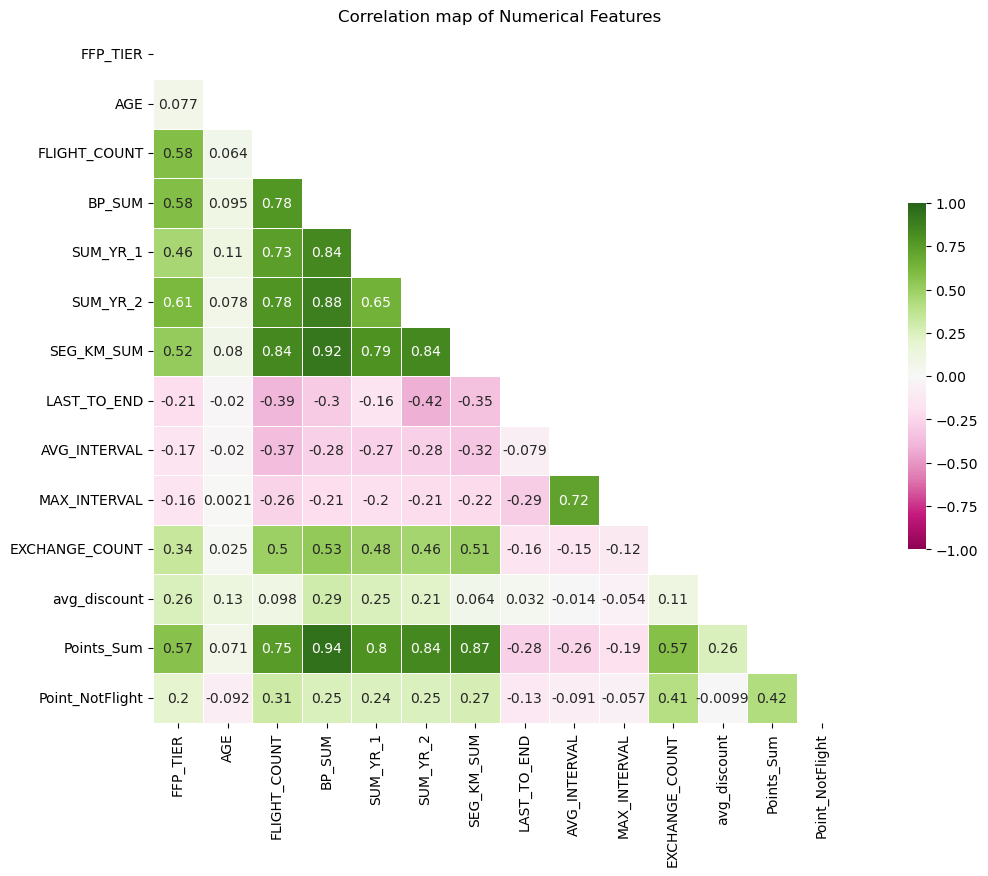

In [11]:
corr = train_df.select_dtypes(include= ["int64", "float64"]).corr()

tri_mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(10,250, as_cmap=True)

_, ax = plt.subplots(figsize=(16,9))
sns.heatmap(corr, mask=tri_mask, cmap="PiYG", 
            center=0, vmin=-1.0, vmax=1.0,
            square=True, annot=True, linewidths=.5,
            cbar_kws={"shrink": .5}, ax=ax)

ax.set_title("Correlation map of Numerical Features")

There seems to exist some level of multicollinearity between numerical predictors in our model. In order to handle that we will run a Variance Inflation Factor analysis to filter out features with high VIF (Higher than 5). A high VIF tells us how much a variable variance is influenced as a linear combination from other features

Variance Inflation Factor is an analysis where you make one of your dataset's features a predicted variable and run a linear regression model with all the remaining features. Then you calculate a R^2 value and your VIF factor can be calculated as mentioned below:

`VIF = 1 / (1 - R^2)`

As this is a Linear Regression model, it will be important to handle nulls and scale variables.

In [12]:
# For simplicity now, we are dropping nulls, as there is a minor impact on data
X = train_df.select_dtypes(include= ["int64", "float64"]).dropna()

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [14]:
def get_vif_factors(predictors_dataframe):
    X = predictors_dataframe.copy()
    
    vif_pipe = Pipeline(steps=[
        ("scale", StandardScaler()),
        ("regression", LinearRegression(n_jobs=3)),
    ])
    
    vif_analysis = []
    for feature in X.columns:
        X_vif = X.drop(feature, axis=1)
        y_vif = X[feature].copy()
        vif_pipe.fit(X_vif, y_vif)
        r2 = vif_pipe.score(X_vif, y_vif)
        vif = 1/ (1 -r2)
        vif_analysis.append((feature, vif))
        
    return pd.Series(dict(vif_analysis), name="VIF").sort_values(ascending=False)

In [15]:
vif = get_vif_factors(X)
vif

BP_SUM             27.629356
Points_Sum         12.260654
SEG_KM_SUM         11.891432
SUM_YR_2            7.026826
FLIGHT_COUNT        5.317585
SUM_YR_1            5.025187
MAX_INTERVAL        2.483087
AVG_INTERVAL        2.273493
FFP_TIER            1.815144
LAST_TO_END         1.708931
Point_NotFlight     1.632882
EXCHANGE_COUNT      1.610215
avg_discount        1.606063
AGE                 1.042024
Name: VIF, dtype: float64

As expected, BP_SUM, Points_Sum, SUM_YR_2, SUM_YR_1, SEG_KM_SUM, FLIGHT_COUNT have a high VIF factor, let's observe our model without VIF features > 5

In [16]:
get_vif_factors(X.drop(vif[vif >= 5.2].index, axis=1))

MAX_INTERVAL       2.388702
AVG_INTERVAL       2.222592
SUM_YR_1           1.631637
EXCHANGE_COUNT     1.508843
FFP_TIER           1.402761
LAST_TO_END        1.246846
Point_NotFlight    1.235337
avg_discount       1.134225
AGE                1.038966
Name: VIF, dtype: float64

In [17]:
numerical_features = vif[vif < 5.2].index.tolist()

In [18]:
numeric_df = train_df[numerical_features].copy()
numeric_df.isnull().sum()

SUM_YR_1           262
MAX_INTERVAL         0
AVG_INTERVAL         0
FFP_TIER             0
LAST_TO_END          0
Point_NotFlight      0
EXCHANGE_COUNT       0
avg_discount         0
AGE                342
dtype: int64

3426.5 6002.575145054624


<Axes: ylabel='Frequency'>

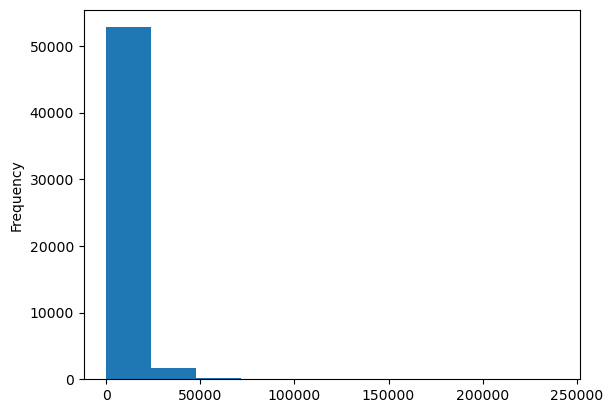

In [19]:
print(numeric_df["SUM_YR_1"].median(), numeric_df["SUM_YR_1"].mean())
numeric_df["SUM_YR_1"].plot(kind="hist")

42.0 42.705788722602364


<Axes: ylabel='Frequency'>

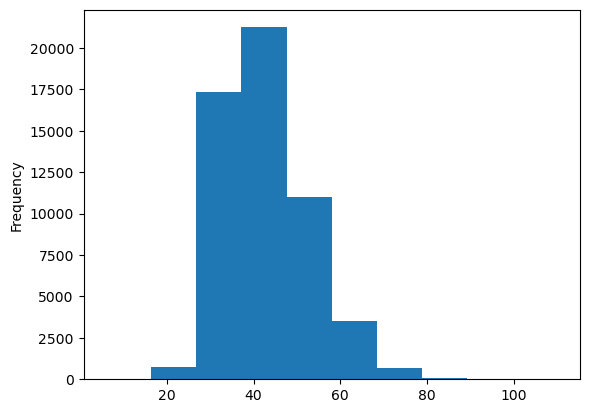

In [20]:
print(numeric_df["AGE"].median(), numeric_df["AGE"].mean())
numeric_df["AGE"].plot(kind="hist")

In [21]:
for feature in numeric_df.columns[numeric_df.isnull().sum() > 0]:
    numeric_df[feature] = numeric_df[feature].fillna(numeric_df[feature].median())

In [22]:
numeric_df.isnull().sum()

SUM_YR_1           0
MAX_INTERVAL       0
AVG_INTERVAL       0
FFP_TIER           0
LAST_TO_END        0
Point_NotFlight    0
EXCHANGE_COUNT     0
avg_discount       0
AGE                0
dtype: int64

### Categorical variables

In [30]:
train_df.select_dtypes(exclude=numerics).describe().T

,count,unique,top,freq
GENDER,54997,2,Male,42504
WORK_CITY,53034,2956,guangzhou,8348
WORK_PROVINCE,52216,1061,guangdong,15388
WORK_COUNTRY,54980,110,CN,50413
LOAD_TIME,55000,1,3/31/2014,55000


In [31]:
test_df.select_dtypes(exclude=numerics).describe().T

,count,unique,top,freq
GENDER,7988,2,Male,5630
WORK_CITY,7685,837,guangzhou,1038
WORK_PROVINCE,7524,280,guangdong,2121
WORK_COUNTRY,7982,49,CN,7335
LOAD_TIME,7988,1,3/31/2014,7988


In [32]:
train_df["WORK_COUNTRY"].value_counts().head(20)

CN    50413
HK      866
JP      829
KR      621
US      521
AU      258
SG      246
TW      215
MY      148
PH      113
FR       97
ID       74
TH       59
NL       47
VN       44
DE       39
CA       38
BE       36
MO       27
VT       27
Name: WORK_COUNTRY, dtype: int64

In [33]:
province_num_countries_count = (
    train_df
    .select_dtypes(exclude=numerics)
    .drop(["LOAD_TIME"], axis=1)
    .groupby(["WORK_PROVINCE"])
    ["WORK_COUNTRY"]
    .nunique()
)

province_num_countries_count[province_num_countries_count > 1].sum() / province_num_countries_count.sum()

0.21202274573517466

As we can see, Work Country > Province > City taxonomi does not seem to be perfectly MECE, there may be some outliers... dropping may lead to information loss. But let's clean a little bit because there are multiple forms of nulls...

In [34]:
categ_df = train_df.select_dtypes(exclude=numerics).drop(["LOAD_TIME"], axis=1)

In [35]:
categ_df["GENDER"].unique()

array(['Male', 'Female', nan], dtype=object)

In [36]:
suspect_cities = categ_df.loc[categ_df["WORK_CITY"].fillna("").map(lambda x: len(x)) <= 2, "WORK_CITY"].unique()


ignore_cities = set([np.nan,"HK","wu","CA","LA","sg","mo","ca","BM","bi","CZ","CN","NC",'NT',
                     'DU', 'US', 'ＴＷ', 'kk', 'KA',"da",'SW', 'ph', 'hk', 'BC','cn', 'jp',
                     'WP','UK', 'NY', 'su', 'UD','S', 'TN', 'SI','SG'])

cities_to_replace_with_nan = list(set(suspect_cities) - set(ignore_cities))
print(cities_to_replace_with_nan)

['0', '`', 'na', '/', 'N', '．', '-', '5', '－', '**', '。', '*', '=', 'J', '\u3000', '1', 'PJ', '\\', '\u3000\u3000', '.', '--']


In [37]:
categ_df.loc[categ_df["WORK_PROVINCE"].fillna("").map(lambda x: len(x)) == 2, "WORK_PROVINCE"].unique()

provinces_to_replace_with_nan = list(set(categ_df.loc[categ_df["WORK_PROVINCE"].fillna("").map(lambda x: len(x)) <= 1, "WORK_PROVINCE"].unique()).union(set(["--","..","**","\u3000\u3000"])))
print(provinces_to_replace_with_nan)

['。', 'S', '0', '`', '/', '*', '=', nan, 'N', '\u3000', '..', '1', '．', '-', '\\', '\u3000\u3000', '**', '.', '－', '--', 'P', 'C', 'W']


In [38]:
categ_df.loc[categ_df["WORK_COUNTRY"].fillna("").map(lambda x: len(x)) <= 1, "WORK_COUNTRY"].unique()
# No need to treat country

array([nan, '中', '北', '沈', '芬'], dtype=object)

In [39]:
categ_df.loc[categ_df["WORK_CITY"].isin(cities_to_replace_with_nan), "WORK_CITY"] = np.nan

In [40]:
categ_df.loc[categ_df["WORK_PROVINCE"].isin(provinces_to_replace_with_nan), "WORK_PROVINCE"] = np.nan

In [41]:
categ_df = categ_df.fillna("NAN")

In [42]:
categ_df.isnull().sum()

GENDER           0
WORK_CITY        0
WORK_PROVINCE    0
WORK_COUNTRY     0
dtype: int64

### Treated dataframe

In [43]:
numeric_df.head()

,SUM_YR_1,MAX_INTERVAL,AVG_INTERVAL,FFP_TIER,LAST_TO_END,Point_NotFlight,EXCHANGE_COUNT,avg_discount,AGE
MEMBER_NO,,,,,,,,,
54993,239560.0,18,3.483254,6,1,50,34,0.961639,31.0
28065,171483.0,17,5.194245,6,7,33,29,1.252314,42.0
55106,163618.0,18,5.298507,6,11,26,20,1.254676,40.0
21189,116350.0,73,27.863636,5,97,12,11,1.090870,64.0
39546,124560.0,47,4.788079,6,5,39,27,0.970658,48.0


In [44]:
categ_df.head()

,GENDER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY
MEMBER_NO,,,,
54993,Male,NAN,beijing,CN
28065,Male,NAN,beijing,CN
55106,Male,NAN,beijing,CN
21189,Male,Los Angeles,CA,US
39546,Male,guiyang,guizhou,CN


In [45]:
datetime_df.head()

,FFP_DATE,FIRST_FLIGHT_DATE,LAST_FLIGHT_DATE
MEMBER_NO,,,
54993,2006-11-02,2008-12-24,2014-03-31
28065,2007-02-19,2007-08-03,2014-03-25
55106,2007-02-01,2007-08-30,2014-03-21
21189,2008-08-22,2008-08-23,2013-12-26
39546,2009-04-10,2009-04-15,2014-03-27


In [46]:
datetime_cols = datetime_df.columns
categ_cols = categ_df.columns
numeric_cols = numeric_df.columns

In [47]:
[print(x.shape) for x in [datetime_df, numeric_df, categ_df]]

(55000, 3)
(55000, 9)
(55000, 4)


[None, None, None]

In [49]:
def get_days_time_step(datetime_series):
    return ((datetime_series - datetime_series.min()) / np.timedelta64("1","D")).astype('int64')

In [50]:
get_vif_factors(datetime_df.apply(get_days_time_step, axis="rows"))

FFP_DATE             4.036666
FIRST_FLIGHT_DATE    4.024929
LAST_FLIGHT_DATE     1.012235
Name: VIF, dtype: float64

In [51]:
get_vif_factors(datetime_df.apply(get_days_time_step, axis="rows").drop("FFP_DATE", axis=1))

LAST_FLIGHT_DATE     1.00929
FIRST_FLIGHT_DATE    1.00929
Name: VIF, dtype: float64

In [54]:
X = (datetime_df.apply(get_days_time_step, axis="rows")
    .join(numeric_df,how='inner')
    .join(categ_df, how='inner'))
X.shape

(55000, 16)

## 3. Selecting model to be used 
- Relatively big dataset (55k instances, 16 features)
- No clear taxonomy in data
- I have no idea how many clusters we should use

Let's try te simples algorithm first: K-Means with elbow method

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

In [57]:
categorical_pipeline = Pipeline(steps=[("encode",OrdinalEncoder(handle_unknown="error")),
                                       ("scale",MinMaxScaler())])

preprocessing = ColumnTransformer(
    transformers=[("datetime", MinMaxScaler(), datetime_cols),
                  ("numeric", MinMaxScaler(), numeric_cols),
                  ("categ", categorical_pipeline, categ_cols)],
    remainder='passthrough', n_jobs=3,)

def get_kmeans_pipeline(n_clusters):
    return  Pipeline(steps=[("preprocessing",preprocessing),
                            ("clustering",KMeans(n_clusters, n_init='auto',random_state=0))])

In [60]:
transformed_X = pd.DataFrame(preprocessing.fit_transform(X), index= X.index, columns=X.columns)
transformed_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55000 entries, 54993 to 21795
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FFP_DATE           55000 non-null  float64
 1   FIRST_FLIGHT_DATE  55000 non-null  float64
 2   LAST_FLIGHT_DATE   55000 non-null  float64
 3   SUM_YR_1           55000 non-null  float64
 4   MAX_INTERVAL       55000 non-null  float64
 5   AVG_INTERVAL       55000 non-null  float64
 6   FFP_TIER           55000 non-null  float64
 7   LAST_TO_END        55000 non-null  float64
 8   Point_NotFlight    55000 non-null  float64
 9   EXCHANGE_COUNT     55000 non-null  float64
 10  avg_discount       55000 non-null  float64
 11  AGE                55000 non-null  float64
 12  GENDER             55000 non-null  float64
 13  WORK_CITY          55000 non-null  float64
 14  WORK_PROVINCE      55000 non-null  float64
 15  WORK_COUNTRY       55000 non-null  float64
dtypes: float64(16)
mem

In [61]:
get_vif_factors(transformed_X)

LAST_TO_END          212548.768089
LAST_FLIGHT_DATE     212532.649521
FIRST_FLIGHT_DATE         4.147956
FFP_DATE                  4.124931
MAX_INTERVAL              2.438832
AVG_INTERVAL              2.240128
WORK_PROVINCE             2.020489
WORK_CITY                 1.719118
SUM_YR_1                  1.661095
EXCHANGE_COUNT            1.551024
WORK_COUNTRY              1.486027
FFP_TIER                  1.435904
Point_NotFlight           1.238958
AGE                       1.167150
avg_discount              1.142150
GENDER                    1.036494
Name: VIF, dtype: float64

In [64]:
get_vif_factors(transformed_X.drop(["LAST_FLIGHT_DATE"], axis=1))

FIRST_FLIGHT_DATE    4.146698
FFP_DATE             4.124560
MAX_INTERVAL         2.429108
AVG_INTERVAL         2.234797
WORK_PROVINCE        2.020457
WORK_CITY            1.718890
SUM_YR_1             1.658561
EXCHANGE_COUNT       1.550486
WORK_COUNTRY         1.486026
FFP_TIER             1.405654
LAST_TO_END          1.275990
Point_NotFlight      1.238957
AGE                  1.167143
avg_discount         1.141559
GENDER               1.036030
Name: VIF, dtype: float64

In [65]:
get_vif_factors(transformed_X.drop(["LAST_FLIGHT_DATE","FFP_DATE"], axis=1))

MAX_INTERVAL         2.421403
AVG_INTERVAL         2.233325
WORK_PROVINCE        2.020455
WORK_CITY            1.718748
SUM_YR_1             1.653725
EXCHANGE_COUNT       1.549218
WORK_COUNTRY         1.484199
FFP_TIER             1.405545
LAST_TO_END          1.270351
Point_NotFlight      1.238680
FIRST_FLIGHT_DATE    1.164302
AGE                  1.150690
avg_discount         1.141465
GENDER               1.035980
Name: VIF, dtype: float64

In [66]:
datetime_cols = list(set(datetime_df.columns) - set(["LAST_FLIGHT_DATE","FFP_DATE"]))
categ_cols = list(categ_df.columns)
numeric_cols = list(numeric_df.columns)

In [67]:
X = X.drop(["LAST_FLIGHT_DATE","FFP_DATE"], axis=1)

In [68]:
X.shape

(55000, 14)

In [71]:
categorical_pipeline = Pipeline(steps=[("encode",OrdinalEncoder(handle_unknown="error")),
                                       ("scale",MinMaxScaler())])

preprocessing = ColumnTransformer(
    transformers=[("datetime", MinMaxScaler(), datetime_cols),
                  ("numeric", MinMaxScaler(), numeric_cols),
                  ("categ", categorical_pipeline, categ_cols)],
    remainder='passthrough', n_jobs=3,)

def get_kmeans_pipeline(n_clusters):
    return  Pipeline(steps=[("preprocessing",preprocessing),
                            ("clustering",KMeans(n_clusters, n_init='auto',random_state=0))])

## 4. Evaluating models

### K-means
- Elbow method on Within Cluster Sum os Squares (Inertia) indicates N=6 is the best clustering
- Silhouette Score is around 0.26 for N=2 and 0.23 for N=3, which is not a good indicator for the clustering quality (should be closer to 1 for better clustering)
- Davies Bouldin score is minimum for N=6, around 1.35. Still was expecting something closer to 0

In [72]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

In [73]:
kmeans_model_pipes = [get_kmeans_pipeline(i) for i in range(2, 16)]

within_cluster_sum_of_squares = []
ch_scores = []
db_scores = []
si_scores = []

for pipe in kmeans_model_pipes:
    idx = pipe.named_steps["clustering"].n_clusters
    pipe.fit(X)
    labels = pipe.predict(X)
    transformed_X = pipe.named_steps["preprocessing"].transform(X)
    
    wcss = pipe.named_steps["clustering"].inertia_
    ch_score = calinski_harabasz_score(transformed_X, labels= labels)
    si_score = silhouette_score(transformed_X, labels= labels, random_state=0)
    db_score = davies_bouldin_score(transformed_X, labels= labels)
    
    within_cluster_sum_of_squares.append((f"n_clusters: {idx}", wcss))
    ch_scores.append((f"n_clusters: {idx}", ch_score))
    si_scores.append((f"n_clusters: {idx}", si_score))
    db_scores.append((f"n_clusters: {idx}", db_score))
    
    print(f"N clusters: {idx} ... done")

N clusters: 2 ... done
N clusters: 3 ... done
N clusters: 4 ... done
N clusters: 5 ... done
N clusters: 6 ... done
N clusters: 7 ... done
N clusters: 8 ... done
N clusters: 9 ... done
N clusters: 10 ... done
N clusters: 11 ... done
N clusters: 12 ... done
N clusters: 13 ... done
N clusters: 14 ... done
N clusters: 15 ... done


Text(0.5, 1.0, 'K-Means Elbow Plot - Inertia (WCSS)')

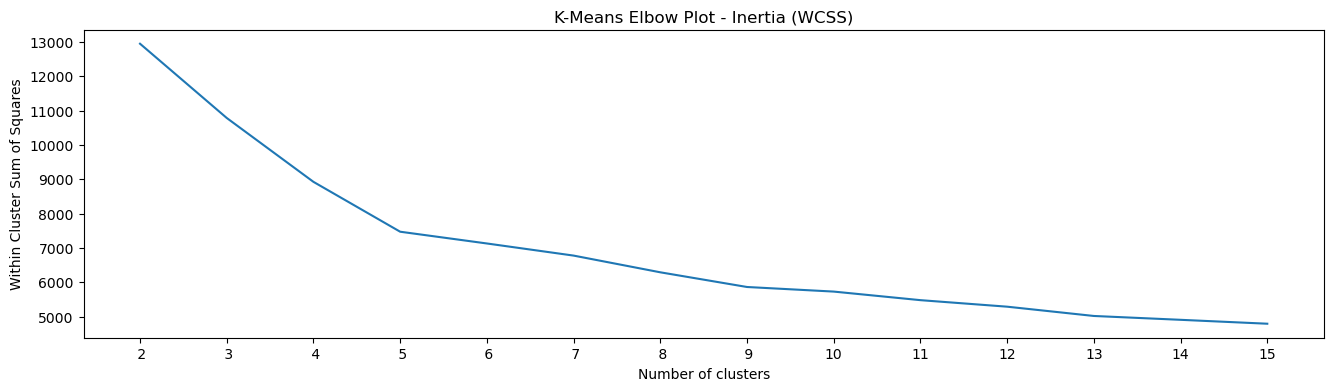

In [74]:
series = pd.Series(dict(within_cluster_sum_of_squares))
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(series.index.str[-2:], series.values)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Within Cluster Sum of Squares")
ax.set_title("K-Means Elbow Plot - Inertia (WCSS)")

Text(0.5, 1.0, 'K-Means Elbow Plot - Calinski Harabasz Scores')

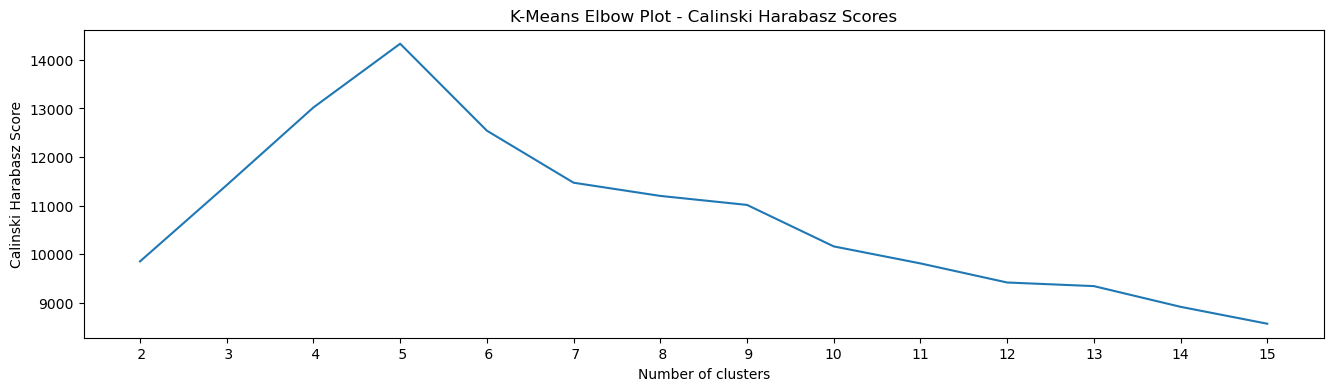

In [75]:
series = pd.Series(dict(ch_scores))
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(series.index.str[-2:], series.values)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Calinski Harabasz Score")
ax.set_title("K-Means Elbow Plot - Calinski Harabasz Scores")

Text(0.5, 1.0, 'K-Means Elbow Plot - Silhouette Scores')

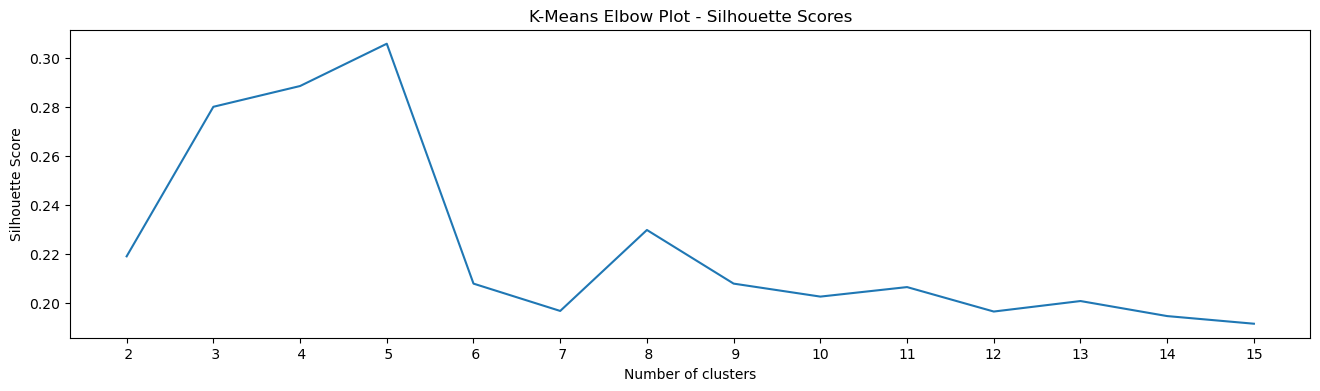

In [76]:
series = pd.Series(dict(si_scores))
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(series.index.str[-2:], series.values)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette Score")
ax.set_title("K-Means Elbow Plot - Silhouette Scores")

Text(0.5, 1.0, 'K-Means Elbow Plot - Davies Bouldin Score')

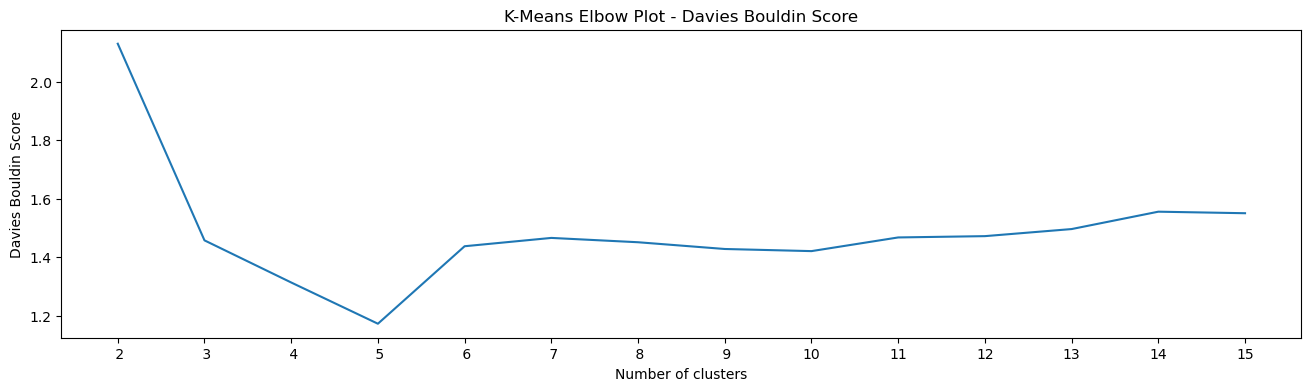

In [77]:
series = pd.Series(dict(db_scores))
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(series.index.str[-2:], series.values)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Davies Bouldin Score")
ax.set_title("K-Means Elbow Plot - Davies Bouldin Score")

In [83]:
def run_kmeans_clustering(n_clusters=3):
    start_time = time.time()

    model = get_kmeans_pipeline(n_clusters)
    model.fit(X)
    labels = model.named_steps["clustering"].labels_
    transformed_X = model.named_steps["preprocessing"].transform(X)

    ch_score = calinski_harabasz_score(transformed_X, labels= labels)
    si_score = silhouette_score(transformed_X, labels= labels, random_state=0)
    db_score = davies_bouldin_score(transformed_X, labels= labels)

    scores = {"Calinski Harabasz": ch_score, 
                     "Silhouette": si_score, 
                     "Davies Bouldin": db_score}
    end_time = time.time()

    print(f"Kmeans: n_clusters={n_clusters}")
    print(f"Execution: {(end_time - start_time): .4f} seconds")
    print(f"Scores: {scores}")
    print("\n")

    return model, scores

In [84]:
best_kmeans, k_means_score = run_kmeans_clustering(5)

Kmeans: n_clusters=5
Execution:  30.8663 seconds
Scores: {'Calinski Harabasz': 14330.600771008898, 'Silhouette': 0.30569287949818946, 'Davies Bouldin': 1.172836584054496}




### DBSCAN
- Kind of difficult to compare to K-means since all metrics are euclidean-based and do not perform well on dbscan vs other metrics

In [85]:
from sklearn.cluster import DBSCAN, OPTICS
import time

In [92]:
def get_dbscan_pipeline(eps = 0.5, min_samples=5):
    model = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=3)
    return  Pipeline(steps=[("preprocessing",preprocessing),
                            ("clustering", model)])

def get_optics_pipeline(min_samples=5):
    model = OPTICS(min_samples=min_samples, n_jobs=3)
    return  Pipeline(steps=[("preprocessing",preprocessing),
                            ("clustering", model)])

In [93]:
def run_dbscan_clustering(eps=0.5, min_samples=5):
    start_time = time.time()

    model = get_dbscan_pipeline(eps=eps, min_samples=min_samples)
    model.fit(X)
    labels = model.named_steps["clustering"].labels_
    transformed_X = model.named_steps["preprocessing"].transform(X)

    ch_score = calinski_harabasz_score(transformed_X, labels= labels)
    si_score = silhouette_score(transformed_X, labels= labels, random_state=0)
    db_score = davies_bouldin_score(transformed_X, labels= labels)

    scores = {"Calinski Harabasz": ch_score, 
                     "Silhouette": si_score, 
                     "Davies Bouldin": db_score}
    end_time = time.time()
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    print(f"DBSCAN: eps={eps}, min_samples={min_samples}, n_clusters={n_clusters}")
    print(f"Execution: {(end_time - start_time): .4f} seconds")
    print(f"Scores: {scores}")
    print("\n")

    return model, scores

In [94]:
model, dbscan_scores = run_dbscan_clustering(eps=0.5, min_samples=5)
dbscan_labels = model.named_steps["clustering"].labels_
# Number of clusters in labels, ignoring noise if present.
dbscan_n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

DBSCAN: eps=0.5, min_samples=5, n_clusters=5
Execution:  113.6212 seconds
Scores: {'Calinski Harabasz': 2265.0391572091808, 'Silhouette': 0.1667747238141956, 'Davies Bouldin': 1.9636608916402327}




### OPTICS
- It takes forever to run...

In [308]:
# start_time = time.time()

# model_op = get_optics_pipeline(min_samples=5)
# model_op.fit(X)
# labels = model_op.named_steps["clustering"].labels_
# transformed_X = model_op.named_steps["preprocessing"].transform(X)

# ch_score = calinski_harabasz_score(transformed_X, labels= labels)
# si_score = silhouette_score(transformed_X, labels= labels, random_state=0)
# db_score = davies_bouldin_score(transformed_X, labels= labels)

# optics_scores = {"Calinski Harabasz": ch_score, 
#                  "Silhouette": si_score, 
#                  "Davies Bouldin": db_score}
# end_time = time.time()

# print(f"OPTICS scores: {dbscan_scores}")
# print(f"Execution time: {(end_time - start_time): .4f} seconds")

## Conclusion